## Table of Contents
0. Initial Setup
1. Part 1
   - 1.1 Analysis of net1
   - 1.2 Analysis of net2
   - 1.3 Analysis of net3
   - 1.4 Analysis of net4
2. Part 2
   - 2.1 Network Visualization
   - 2.2 Observations and Hypothesis
   - 2.3 Algorithm Construction for the Model
   - 2.4 Algorithm proposal testing
3. Conclusion





## 0. Initial setup

In [68]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from collections import Counter
from itertools import combinations
report_folder = "report"
import math
if not os.path.exists(report_folder):
    os.makedirs(report_folder)

plt.style.use('ggplot')
%matplotlib inline

The `load_network` function reads a network from a Pajek file, converts it into a simple undirected graph, and relabels the nodes with integer values.

In [6]:
def load_network(name):
    """
    Load and preprocess a network from a Pajek file.

    Parameters:
        name (str): The name of the Pajek file (without extension).

    Returns:
        networkx.Graph: A simple undirected graph with integer-labeled nodes.
    """
    G = nx.read_pajek(f'data/{name}.net')

    # Convert to simple undirected graph
    G = nx.Graph(G)

    # Convert node labels to integers
    G = nx.convert_node_labels_to_integers(G)

    return G


The `calculate_network_descriptors` function computes key structural and macroscopic properties of the network.


In [7]:
def calculate_network_descriptors(G):
    """
    Compute key structural and macroscopic descriptors for the given network.

    Parameters:
        G (networkx.Graph): The input graph.

    Returns:
        dict: A dictionary containing the following metrics:
            - 'nodes': Number of nodes in the network.
            - 'edges': Number of edges in the network.
            - 'self_loops': Number of self-loops.
            - 'multi_edges': Number of multi-edges.
            - 'degree_min': Minimum node degree.
            - 'degree_max': Maximum node degree.
            - 'degree_avg': Average node degree.
            - 'clustering': Average clustering coefficient.
            - 'assortativity': Degree assortativity coefficient.
            - 'avg_path_length': Average shortest path length (largest connected component).
            - 'diameter': Diameter of the largest connected component.
    """
    # Basic properties
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    degrees = [d for _, d in G.degree()]

    # Self-loops and multi-edges checks
    self_loops = nx.number_of_selfloops(G)
    multi_edges = sum(1 for edge in G.edges() if G.number_of_edges(edge[0], edge[1]) > 1)

    # Diameter analysis
    largest_cc = max(nx.connected_components(G), key=len)
    g_largest_cc = G.subgraph(largest_cc)

    return {
        'nodes': n_nodes,
        'edges': n_edges,
        'self_loops': self_loops,
        'multi_edges': multi_edges,
        'degree_min': np.min(degrees),
        'degree_max': np.max(degrees),
        'degree_avg': np.mean(degrees),
        'clustering': nx.average_clustering(G),
        'assortativity': nx.degree_assortativity_coefficient(G),
        'avg_path_length': nx.average_shortest_path_length(g_largest_cc),
        'diameter': nx.diameter(g_largest_cc),
    }

The `calculate_centralities` function computes key centrality measures for the nodes in a given network.

In [8]:
def calculate_centralities(G):
    """
    Compute node centrality measures for a single network.

    Parameters:
        G (networkx.Graph): The input graph.

    Returns:
        tuple: A tuple containing:
            - net_name: The name of the network.
            - dict: A dictionary with centrality measures:
                - 'betweenness': Betweenness centrality for each node.
                - 'degree': Degree centrality for each node.
                - 'eigenvector': Eigenvector centrality for each node.
    """
    return {
        'betweenness': nx.betweenness_centrality(G),
        'degree': dict(G.degree()),
        'eigenvector': nx.eigenvector_centrality(G)
    }

The function `get_top_central_nodes` extracts the top N most central nodes for each centrality metric from a given dictionary of centrality measures.

In [9]:
def get_top_central_nodes(centrality_dict, top_n=5):
    """
    Retrieve the top N most central nodes for each centrality metric.

    Parameters:
        centrality_dict (dict): A dictionary containing centrality measures.
        top_n (int): Number of top nodes to retrieve (default is 5).

    Returns:
        dict: A dictionary with the top N nodes for each metric.
    """
    top_nodes = {}
    for metric, values in centrality_dict.items():
        # Sort nodes by centrality value in descending order
        sorted_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)
        # Take the top N nodes
        top_nodes[metric] = [node for node, _ in sorted_nodes[:top_n]]
    return top_nodes

The function `plot_degree_distribution` visualizes the degree distribution of a network in both linear and logarithmic scales.

In [10]:
def plot_degree_distribution(degree_sequence, net_name):
    """
    Plot degree distribution in both linear and logarithmic scales.

    Parameters:
        degree_sequence (list): List of node degrees
        net_name (str): Network name for title and filename
    """

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    degree_counts = Counter(degree_sequence)
    min_degree = min(degree_sequence)
    max_degree = max(degree_sequence)

    degree = list(range(min_degree, max_degree + 1))
    degree_count = [degree_counts.get(x, 0) for x in degree]

    ax[0].scatter(degree, degree_count, label='data')
    ax[0].set_xlabel('$k$', fontsize=15)
    ax[0].set_ylabel('$P(k)$', fontsize=15)
    ax[0].tick_params(which='major', axis='both', labelsize=15)
    ax[0].set_title('Linear scale', fontsize=15)

    ax[1].scatter(degree, degree_count, label='data')
    ax[1].set_xlabel('$k$', fontsize=15)
    ax[1].set_ylabel('$P(k)$', fontsize=15)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].tick_params(which='major', axis='both', labelsize=15)
    ax[1].set_title('Logarithmic scale', fontsize=15)

    plt.tight_layout()

    # Aggiunta unica: salvataggio
    plt.savefig(f'report/{net_name}_degree_distribution.png', bbox_inches='tight')

In [62]:
def visualize_net(G, pos_dict, title):
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos=pos_dict, node_size=100, node_color='blue', edge_color='gray', alpha=0.7)

    plt.title(title)
    plt.show()


## 1. Part 1
Let's start by loading the networks from the files.

In [12]:
NETWORK_NAMES = ['net1', 'net2', 'net3', 'net4']

networks = {}
for net_name in NETWORK_NAMES:
    networks[net_name] = load_network(net_name)


Let's calculate the descriptors and the centralities for each network.

In [13]:
with tqdm_joblib(total=len(networks), desc="Analyzing networks"):
    descriptors = Parallel(n_jobs=-1)(delayed(calculate_network_descriptors)(G) for G in networks.values())

Analyzing networks: 100%|██████████| 4/4 [04:15<00:00, 63.82s/it] 


In [14]:
with tqdm_joblib(total=len(networks), desc="Calculating centralities"):
    centralities = Parallel(n_jobs=-1)(delayed(calculate_centralities)(G) for G in networks.values())

Calculating centralities: 100%|██████████| 4/4 [01:51<00:00, 27.75s/it]


Let's calculate the top 5 nodes with the highest centrality based on the various metrics for each network and save the results in dataframes

In [15]:
top_nodes_per_network = {}
for net_name, centrality_dict in zip(networks.keys(), centralities):
    top_nodes_per_network[net_name] = get_top_central_nodes(centrality_dict, 5)

df_centralities = {}
for network_name in networks.keys():
    df_centralities[network_name] = pd.DataFrame(top_nodes_per_network[network_name], index=["1","2","3","4","5"]).T

    file_name = f"{network_name}_centralities.md"  # Usa il nome della rete come nome del file
    file_path = os.path.join("report", file_name)

    with open(file_path, 'w') as file:
        file.write(df_centralities[network_name].to_markdown())


Let's save the descriptors results in a dataframe

In [16]:
df_descriptors = pd.DataFrame(descriptors, index=["net1","net2","net3","net4"])

file_name = f"networks_descriptors.md"  # Usa il nome della rete come nome del file
file_path = os.path.join("report", file_name)

with open(file_path, 'w') as file:
    file.write(df_descriptors.to_markdown())


To systematically identify the generative mechanism behind each network, we begin by examining the key macroscopic properties, microscopic node centrality patterns, and degree distribution of each network.

This multi-faceted analysis serves to identify the network's fundamental organizational principles and ultimately determine which generative model (ER, WS, BA, or Configuration Model) best explains its structure.

## 1.1 Network 1 Analysis

In [17]:
df_descriptors.iloc[[0]]

,nodes,edges,self_loops,multi_edges,degree_min,degree_max,degree_avg,clustering,assortativity,avg_path_length,diameter
net1,5000,25000,0,0,6,16,10.0,0.41407,-0.009733,5.121125,8


In [18]:
df_centralities['net1']

,1,2,3,4,5
betweenness,4747,2645,230,4360,1579
degree,1693,651,1579,4891,41
eigenvector,651,1937,4526,4398,1939


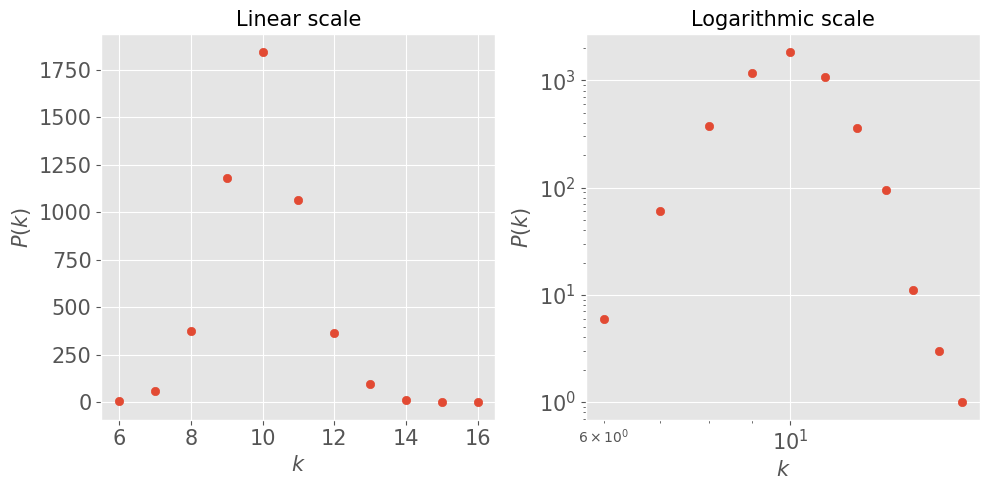

In [19]:
net1_centralities = centralities[0]
degree_sequence_net1 = list(net1_centralities['degree'].values())
plot_degree_distribution(degree_sequence_net1,'net1')

From the analysis of the degree distribution and the clustering coefficient of the network, it is possible to assert with high probability that the network was generated according to the Watts-Strogatz model.

Networks constructed following this model exhibit the following characteristics:
- A degree distribution similar to a Poisson distribution.
- A high clustering coefficient ($CC \geq 0.1$), which is typical of networks that exhibit the small-world property.


## 1.2 Network 2 analysis

In [20]:
df_descriptors.iloc[[1]]

,nodes,edges,self_loops,multi_edges,degree_min,degree_max,degree_avg,clustering,assortativity,avg_path_length,diameter
net2,5000,24873,0,0,1,24,9.9492,0.002099,-0.005663,3.95605,7


In [21]:
df_centralities['net2']

,1,2,3,4,5
betweenness,1581,787,4382,52,2375
degree,1581,787,52,1990,2372
eigenvector,1581,3233,787,2375,131


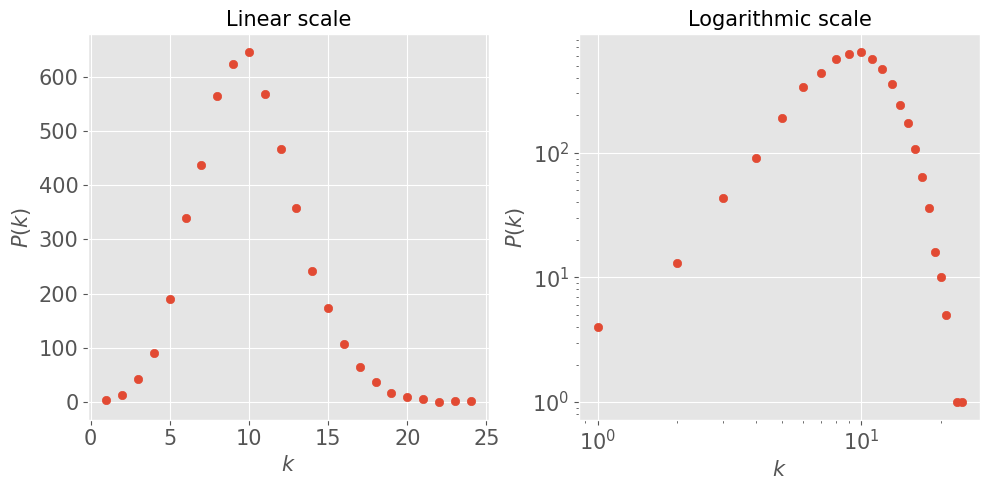

In [22]:
net2_centralities = centralities[1]
degree_sequence_net2 = list(net2_centralities['degree'].values())
plot_degree_distribution(degree_sequence_net2,'net2')


The degree distribution analysis suggests that this network was generated using the Erdős-Rényi (ER) random graph model. Indeed, the observed degree distribution exhibits a **Poisson-like form**, characterized by a symmetric distribution around the average degree $ ( \langle k \rangle )$.

To verify the validity of this assumption, we can consider the following key properties of networks generated under this model:

- The average degree is given by

  $$ \langle k \rangle \sim p (N - 1) $$

- The clustering coefficient is

  $$ CC = p $$

Therefore, to determine with high probability whether this network was generated following the ER model, it is sufficient to compute $( CC(N - 1) )$ and compare it with the average degree.


In [23]:
avg_degree = 9.9492
N = 5000
CC = 0.0020994830917276737

print(CC * (N-1))


10.49531597554664


Since $ 9.94 \sim 10.4 $, we can conclude that, with high probability, the hypothesis is correct and the network was generated according to the ER model.

## 1.3 Network 3 Analysis

In [24]:
df_descriptors.iloc[[2]]

,nodes,edges,self_loops,multi_edges,degree_min,degree_max,degree_avg,clustering,assortativity,avg_path_length,diameter
net3,5000,23508,16,0,3,732,9.4032,0.086214,-0.13386,3.008243,5


In [25]:
df_centralities['net3']


,1,2,3,4,5
betweenness,5,7,0,2,6
degree,5,7,2,0,6
eigenvector,5,7,2,0,3


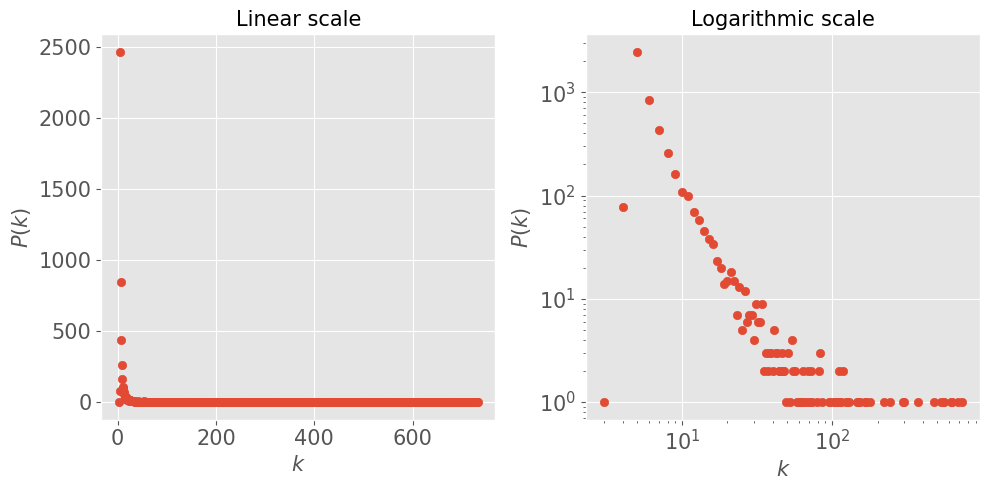

In [26]:
net3_centralities = centralities[2]
degree_sequence_net3= list(net3_centralities['degree'].values())
plot_degree_distribution(degree_sequence_net3,'net3')

It is evident from the structural characteristics of the network that it was generated according to the Configuration Model (CM).

In particular, the network exhibits 16 self-loops, which are a direct consequence of the nature of networks following this model.


## 1.4 Network 4 Analysis

In [27]:
df_descriptors.iloc[[3]]

,nodes,edges,self_loops,multi_edges,degree_min,degree_max,degree_avg,clustering,assortativity,avg_path_length,diameter
net4,5000,24975,0,0,5,210,9.99,0.010729,-0.032451,3.486817,5


In [28]:
df_centralities['net4']

,1,2,3,4,5
betweenness,0,6,9,8,3
degree,6,0,9,10,8
eigenvector,6,0,9,8,3


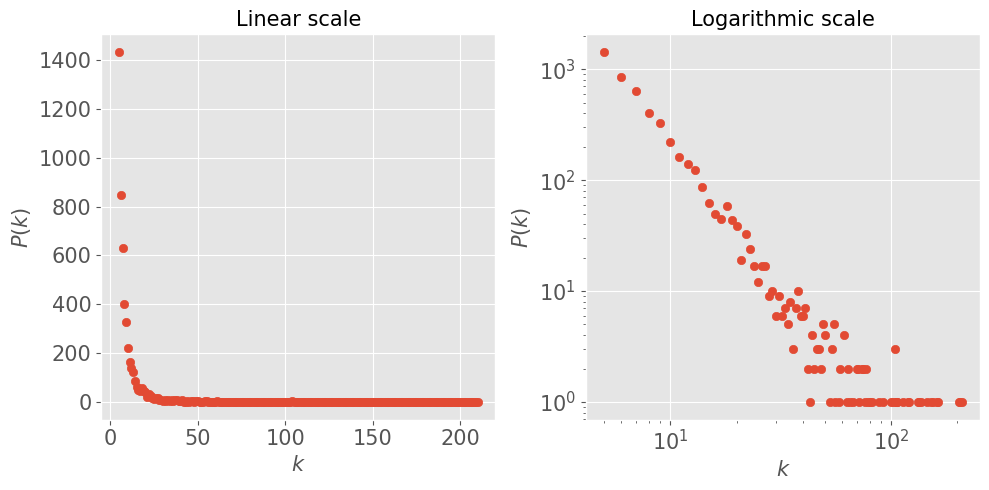

In [29]:
net4_centralities = centralities[3]
degree_sequence_net4= list(net4_centralities['degree'].values())
plot_degree_distribution(degree_sequence_net4,'net4')

There are two pieces of evidence supporting the assertion that, with high probability, network number 4 was generated according to the Barabási-Albert model:

1. The network exhibits a power-law distribution, which can be observed by analyzing the degree distribution on a log-log scale.
2. Additionally, examining the nodes with the highest degree, it is evident that they all have low indices. This is a consequence of the algorithm used, which favors the attachment of new edges to the earliest nodes introduced in the network.


## 1.5 Conclusions

In conclusion, based on the observations made, the networks can be classified as follows:

| Network  | Model                |
|----------|----------------------|
| Network 1 | Watts-Strogatz       |
| Network 2 | Erdős-Rényi          |
| Network 3 | Configuration Model  |
| Network 4 | Barabási-Albert      |


# 2. Part 2

## 2.1 Network Visualization

Let's load and visualize the network 5

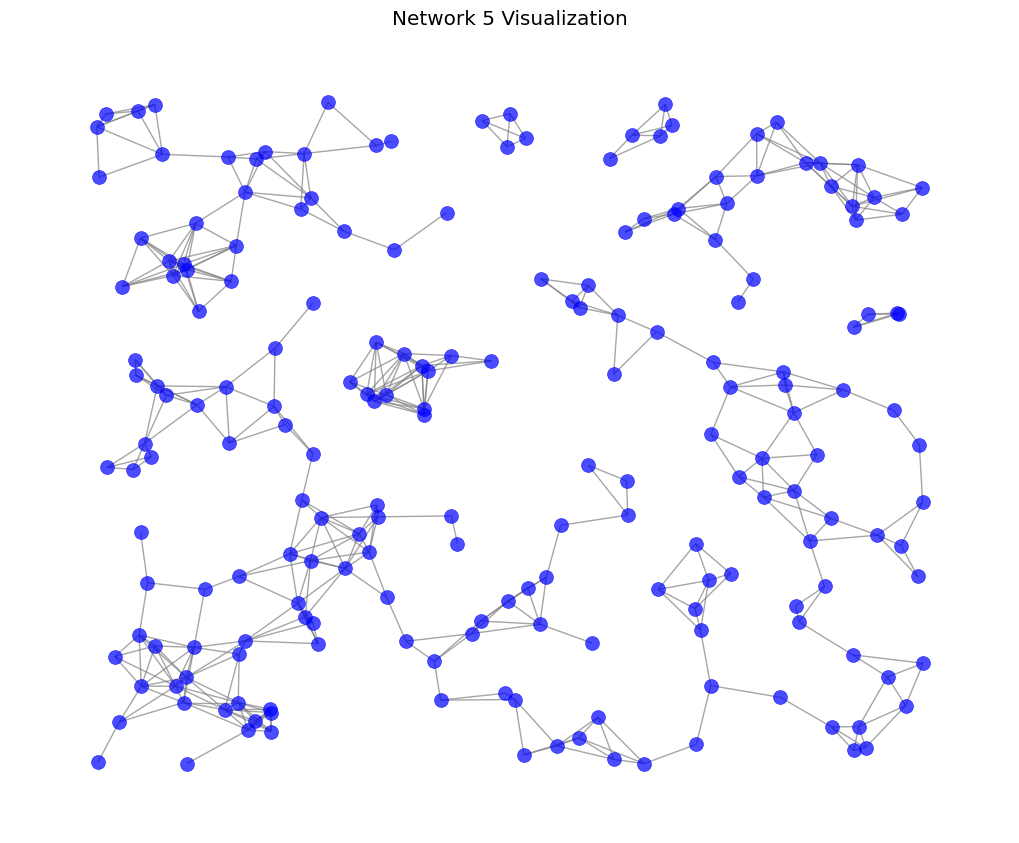

In [64]:

G = load_network('net5')
pos= np.loadtxt('data/positions_net5.txt', skiprows=1)
pos_dict = {int(row[0]): (row[1], row[2]) for row in pos}

visualize_net(G, pos_dict, "Network 5 Visualization")


## 2.2 Observation and hypothesis

We know a priori that all nodes were randomly generated in space. The model, therefore, only determines how and in what order edges are added between them.


Observation 1: By analyzing the network, it is immediately evident that nodes in close proximity are always connected by an edge, whereas edges between distant nodes are much rarer.


Observation 2: Furthermore, in the case of distant nodes that are connected by an edge, it appears that all other node pairs with a smaller distance also have an edge.

Based on these observations, the hypothesis is that the criterion for adding new edges is based on the physical space in which the nodes are located. Thus, the nodes' coordinates are likely attributes of the nodes, as they define a notion of distance between them.

Additionally, Observation 2 suggests that edges are inserted in a specific order. More precisely, the hypothesis is that, given a predetermined number of edges, at each iteration of the model’s algorithm, an edge is added between the pair of nodes with the smallest distance, provided they are not already connected.


## 2.3 Algorithm Construction for the Model

Our proposed algorithm for the possible model that could have generated this network is as follows:

1. Compute all possible pairs of nodes in the network.
2. For each pair of nodes, calculate the Euclidean distance between them.
3. Sort the list of node pairs in ascending order based on their distance.
4. Iteratively add an edge to the pair of nodes with the smallest distance until the predefined number of edges is reached.


In [80]:
def euclidean_distance_model(G,pos_dict,n_edges):
    nodes = list(pos_dict.keys())
    pairs = combinations(nodes, 2)
    distance_list = []
    for u, v in pairs:
        x1 , y1 = pos_dict[u]
        x2, y2 = pos_dict[v]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        distance_list.append((distance, u, v))

    distance_list.sort(key=lambda x: x[0])

    ordered_pairs = [(u, v) for (d, u, v) in distance_list]

    for i in range(n_edges):
        G.add_edge(ordered_pairs[i][0], ordered_pairs[i][1])
    return G

## 2.4 Algorithm proposal testing

Lets testing the algorithm. Firstly we need to remove all the edges from the initial network in order to start from the basic configuration

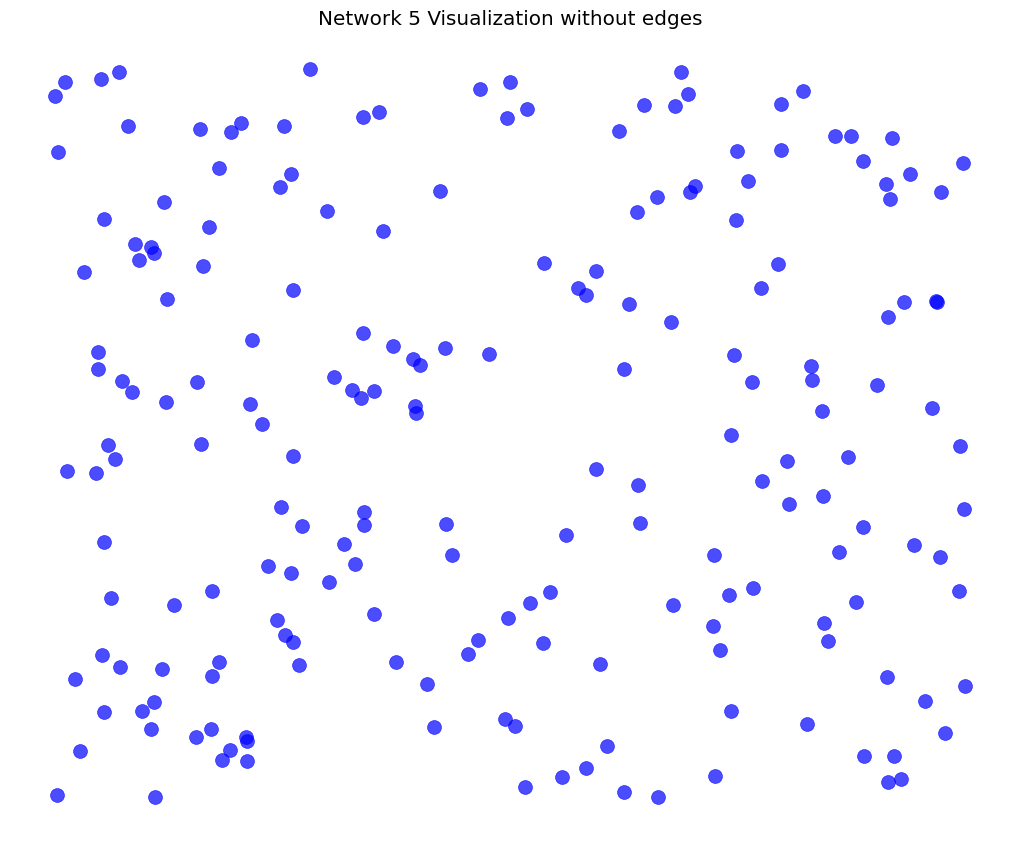

In [86]:
G_testing = G.copy()
G_testing.clear_edges()

visualize_net(G_testing, pos_dict, "Network 5 Visualization without edges")

We can now test the algorithm. Let's see how many nodes there are in the initial network and then we can test the proposal model.

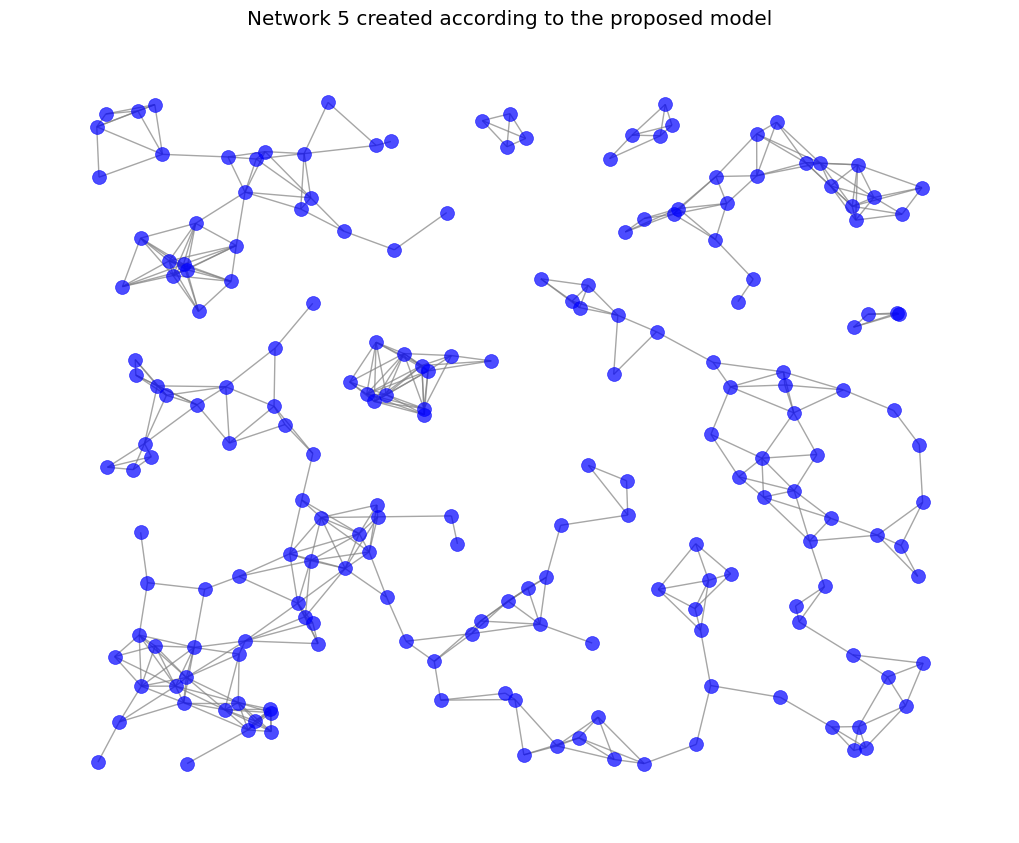

In [89]:
n_edge = G.number_of_edges()

G_testing = euclidean_distance_model(G_testing,pos_dict,n_edge)

visualize_net(G_testing, pos_dict, "Network 5 created according to the proposed model")

Let's see if the edges are the same in both the networks, the first one and the new created

In [88]:
print(set(G.edges()) == set(G_testing.edges()))

True
